## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import scipy.optimize as sco
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import kurtosis, skew, shapiro, norm

## Data

In [3]:
data = pd.read_csv('./input/Quant_Invest_Fundusze.csv', sep=';')
data.index = pd.to_datetime(data['Daty'])
data['Daty'] = pd.to_datetime(data['Daty'])  # duplicated index for easy use of seaborn
ts_cols = [col for col in data.columns if not col == 'Daty']
data[ts_cols] = data[ts_cols].astype(np.float32) # reduce float size for speed and less RAM
data.sort_index(inplace=True)

In [4]:
monthly = data.drop(['Daty'], axis = 1).resample('M').first() # resample.('W') gives significantly higher srri xD 
m_returns = monthly.pct_change().iloc[1:]

In [5]:
m_returns.head()

,AP,ARR,ARW,G,OP,ORR,ORW
Daty,,,,,,,
2000-02-29,0.041861,-0.045255,-0.000057,0.012760,0.007234,0.004114,-0.009362
2000-03-31,0.141469,0.008603,0.027424,0.013042,-0.011658,0.006548,0.042133
2000-04-30,-0.037140,0.047393,-0.022683,0.015716,0.016652,0.014039,0.014904
2000-05-31,-0.060852,-0.028872,-0.076512,0.013799,-0.003305,-0.002908,-0.017498
2000-06-30,0.017149,-0.011937,-0.029605,0.014295,-0.007856,0.007450,-0.011957


In [6]:
m_returns.mean()*12

AP     0.067541
ARR    0.046874
ARW    0.077675
G      0.048417
OP     0.068662
ORR    0.034327
ORW    0.080749
dtype: float32

## SRRI

In [7]:
def srri_variance_monthly(w_returns: pd.DataFrame, **kw:'weights list'):
    
    period = min(w_returns.shape[0], 60)
    
    last_5y = w_returns.iloc[-period:]

    variance_df = last_5y.sub(last_5y.mean(),axis = 1).apply(lambda x: x**2)
    
    variance_vector = np.sqrt(variance_df.sum()*(12/(period-1)))
    
    if('weights' in kw):
        portfolio_variance = sum(np.multiply(variance_vector, kw['weights']))
        return(portfolio_variance)
    else:
        return(variance_vector)

    

In [8]:
srri_variance_monthly(m_returns,weights = [1/7 for i in range(7)]) # equal, 

0.06567863647692969

In [9]:
srri_variance_monthly(m_returns)

AP     0.123547
ARR    0.094240
ARW    0.130424
G      0.001056
OP     0.026063
ORR    0.032299
ORW    0.052121
dtype: float32

## Testing for Normality

In [41]:
def normality_plots(df):
    fig, ax = plt.subplots(nrows=2, ncols=len(df.columns), figsize=(20,10))

    for i, col in enumerate(df.columns):
      mu = np.mean(df[col])
      sigma = np.std(df[col])
      x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

      ax[0,i].hist(df[col], bins =50, density = True)
      ax[0,i].plot(x,norm.pdf(x, mu, sigma))
      ax[0,i].set_title(col)
      qqplot(df[col], line='s', ax =ax[1,i] )

    plt.show()

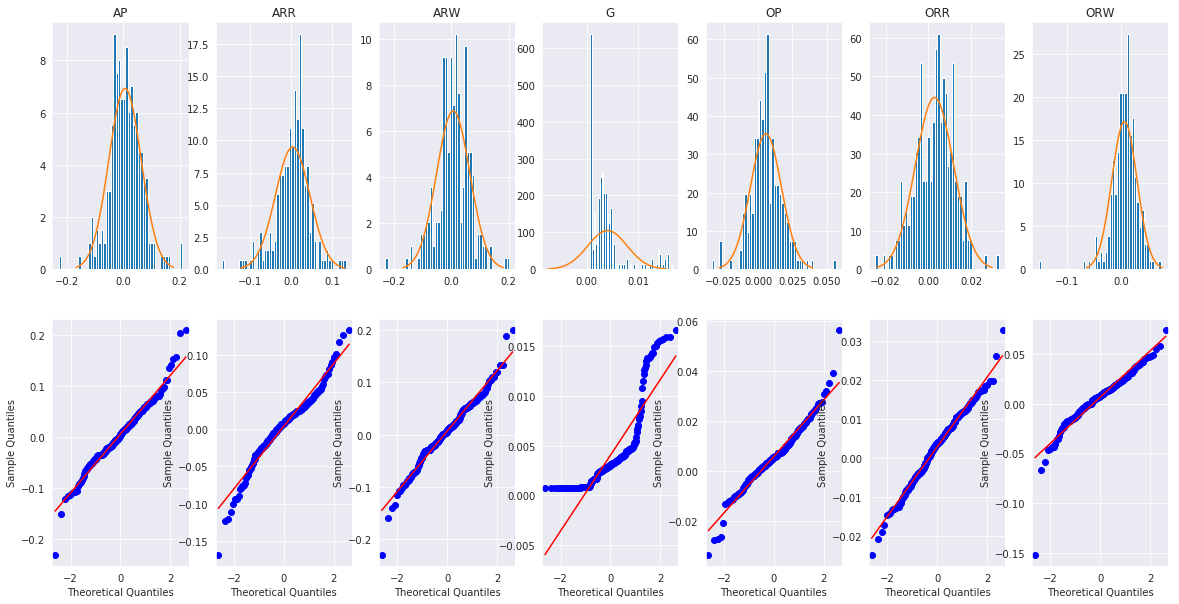

In [42]:
normality_plots(m_returns)

## Risk to return

In [11]:
risk_return = pd.DataFrame({'SRRI':srri_variance_monthly(m_returns), 'Mean_Returns':m_returns.iloc[-260:].mean()*52, 'type':m_returns.columns}, index = None)

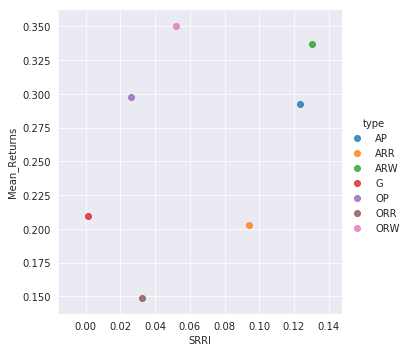

In [12]:
sns.set_style("darkgrid")
sns.lmplot('SRRI', 'Mean_Returns', data=risk_return, hue='type', fit_reg=False)

## Ledoit-Wolf Shrinkage

In [13]:
from sklearn.covariance import LedoitWolf

In [14]:
std_cov = m_returns.cov()
lw_cov = LedoitWolf().fit(m_returns).covariance_
prct_change = (lw_cov-std_cov)/std_cov

In [15]:
pd.DataFrame(lw_cov)

,0,1,2,3,4,5,6
0,0.003258,0.001566,0.002326,-0.000021,0.000116,-0.000107,0.000596
1,0.001566,0.001758,0.002038,-0.000024,0.000068,-0.000095,0.000558
2,0.002326,0.002038,0.003304,-0.000025,0.000111,-0.000111,0.000872
3,-0.000021,-0.000024,-0.000025,0.000052,0.000012,0.000005,0.000005
4,0.000116,0.000068,0.000111,0.000012,0.000162,0.000043,0.000109
5,-0.000107,-0.000095,-0.000111,0.000005,0.000043,0.000116,0.000045
6,0.000596,0.000558,0.000872,0.000005,0.000109,0.000045,0.000564


In [16]:
round(prct_change, 4)

,AP,ARR,ARW,G,OP,ORR,ORW
AP,-0.0216,-0.0329,-0.0329,-0.0329,-0.0329,-0.0329,-0.0329
ARR,-0.0329,-0.0117,-0.0329,-0.0329,-0.0329,-0.0329,-0.0329
ARW,-0.0329,-0.0329,-0.0218,-0.0329,-0.0329,-0.0329,-0.0329
G,-0.0329,-0.0329,-0.0329,2.5639,-0.0329,-0.0329,-0.0329
OP,-0.0329,-0.0329,-0.0329,-0.0329,0.2615,-0.0329,-0.0329
ORR,-0.0329,-0.0329,-0.0329,-0.0329,-0.0329,0.4349,-0.0329
ORW,-0.0329,-0.0329,-0.0329,-0.0329,-0.0329,-0.0329,0.0363


## GARCH

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model
import datetime as dt

In [133]:
split_date = dt.datetime(2018,1,1)

In [35]:
ap_sq = pd.DataFrame({'var':m_returns['AP'].apply(lambda x : x**2), 'Date':m_returns.index})

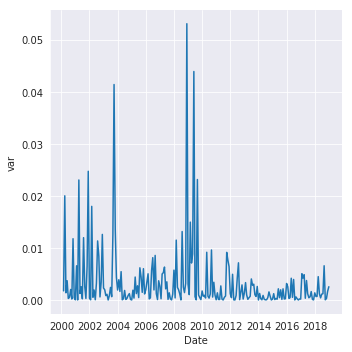

In [78]:
sns.relplot(x="Date", y="var", kind="line", data=ap_sq)

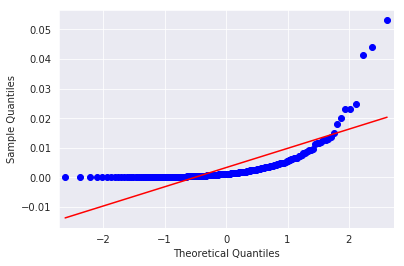

In [77]:
qqplot(ap_sq['var'], line='s')
plt.show()

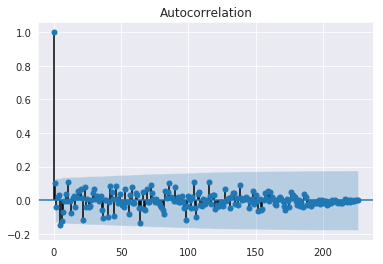

In [117]:
plot_acf(m_returns['ORR'])
plt.show()

### ARR

In [134]:
arr_model = arch_model(m_returns['ARR'], vol='Garch', p=1, o=0, q=1, dist='t')
arr_res = arr_model.fit(update_freq=5, last_obs = split_date)
arr_res.summary()

Iteration:      5,   Func. Count:     47,   Neg. LLF: -232.50173108539178
Iteration:     10,   Func. Count:     89,   Neg. LLF: -390.0893965024732
Iteration:     15,   Func. Count:    131,   Neg. LLF: -400.0794623921299
Iteration:     20,   Func. Count:    171,   Neg. LLF: -406.2050272900814
Iteration:     25,   Func. Count:    211,   Neg. LLF: -408.1574999795117
Iteration:     30,   Func. Count:    247,   Neg. LLF: -409.5155279891251
Iteration:     35,   Func. Count:    283,   Neg. LLF: -409.5348966677015
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -409.53530596339596
            Iterations: 37
            Function evaluations: 297
            Gradient evaluations: 37


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                          ARR   R-squared:                      -0.014
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.014
Vol Model:                            GARCH   Log-Likelihood:                409.535
Distribution:      Standardized Student's t   AIC:                          -809.071
Method:                  Maximum Likelihood   BIC:                          -792.217
                                              No. Observations:                  215
Date:                      Mon, Feb 18 2019   Df Residuals:                      210
Time:                              23:05:34   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         9.1196e-03  2.073e-03      4.399  1.087e-05 [5.056e-03,1.318e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.6664e-05  8.964e-05      1.078      0.281 [-7.903e-05,2.724e-04]
alpha[1]       0.2733  9.613e-02      2.843  4.464e-03    [8.493e-02,  0.462]
beta[1]        0.6831      0.120      5.670  1.428e-08      [  0.447,  0.919]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu            12.3593      8.554      1.445      0.148 [ -4.406, 29.124]
========================================================================

Covariance estimator: robust
"""

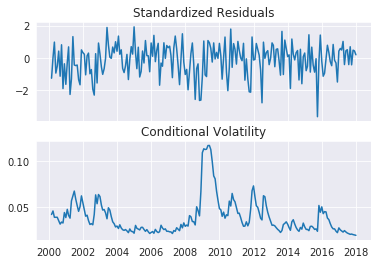

In [135]:
arr_res.plot()
plt.show()

### ARW

In [132]:
arw_model = arch_model(m_returns['ARW'], vol='Garch', p=1, o=0, q=1, dist='t')
arw_res = arw_model.fit(update_freq=5, last_obs = split_date)
arw_res.summary()

Iteration:      5,   Func. Count:     50,   Neg. LLF: -321.3528719469629
Iteration:     10,   Func. Count:     87,   Neg. LLF: -321.6967368040531
Iteration:     15,   Func. Count:    122,   Neg. LLF: -321.77218470379876
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -321.77410313902067
            Iterations: 16
            Function evaluations: 141
            Gradient evaluations: 16


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                          ARW   R-squared:                      -0.003
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.003
Vol Model:                            GARCH   Log-Likelihood:                321.774
Distribution:      Standardized Student's t   AIC:                          -633.548
Method:                  Maximum Likelihood   BIC:                          -616.695
                                              No. Observations:                  215
Date:                      Mon, Feb 18 2019   Df Residuals:                      210
Time:                              23:04:51   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0101  3.708e-03      2.713  6.667e-03 [2.793e-03,1.733e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.2324e-04  2.410e-04      1.341      0.180 [-1.492e-04,7.956e-04]
alpha[1]       0.1846  7.017e-02      2.630  8.536e-03    [4.702e-02,  0.322]
beta[1]        0.7171      0.110      6.505  7.768e-11      [  0.501,  0.933]
                                 Distribution                                
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
nu            54.8811    167.649      0.327      0.743 [-2.737e+02,3.835e+02]
=============================================================================

Covariance estimator: robust
"""

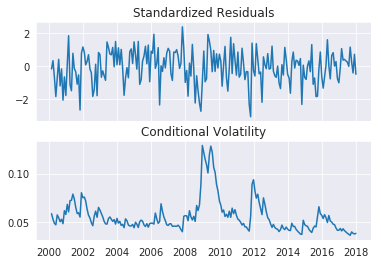

In [136]:
arw_res.plot()
plt.show()

### AP

In [137]:
ap_model = arch_model(m_returns['AP'], vol='Garch', p=1, o=0, q=1, dist='t')
ap_res = ap_model.fit(update_freq=5, last_obs = split_date)
ap_res.summary()

Iteration:      5,   Func. Count:     50,   Neg. LLF: -319.11749137761547
Iteration:     10,   Func. Count:     85,   Neg. LLF: -319.12036536905623
Iteration:     15,   Func. Count:    120,   Neg. LLF: -319.1205719359306
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -319.12057193593114
            Iterations: 15
            Function evaluations: 120
            Gradient evaluations: 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                           AP   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                319.121
Distribution:      Standardized Student's t   AIC:                          -628.241
Method:                  Maximum Likelihood   BIC:                          -611.388
                                              No. Observations:                  215
Date:                      Mon, Feb 18 2019   Df Residuals:                      210
Time:                              23:07:00   Df Model:                            5
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         6.9775e-03  3.645e-03      1.914  5.562e-02 [-1.675e-04,1.412e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.3424e-04  2.251e-04      0.596      0.551 [-3.069e-04,5.754e-04]
alpha[1]       0.1212      0.130      0.933      0.351      [ -0.133,  0.376]
beta[1]        0.8375      0.177      4.741  2.127e-06      [  0.491,  1.184]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu            11.6786      8.219      1.421      0.155 [ -4.430, 27.787]
========================================================================

Covariance estimator: robust
"""

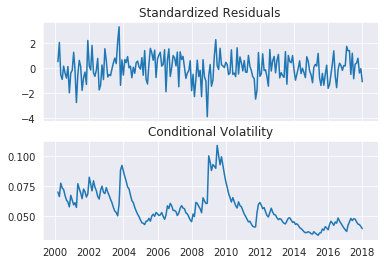

In [138]:
ap_res.plot()
plt.show()

### OP

In [140]:
op_model = arch_model(m_returns['OP'], vol='Garch', p=1, o=0, q=1, dist='t')
op_res = op_model.fit(update_freq=5, last_obs = split_date)
op_res.summary()

Iteration:      5,   Func. Count:     48,   Neg. LLF: -245.18000378979772
Iteration:     10,   Func. Count:     97,   Neg. LLF: -648.5989352074733
Iteration:     15,   Func. Count:    136,   Neg. LLF: -664.0378623998743
Iteration:     20,   Func. Count:    171,   Neg. LLF: -667.0946758888338
Iteration:     25,   Func. Count:    206,   Neg. LLF: -667.458924672479
Iteration:     30,   Func. Count:    241,   Neg. LLF: -667.5063388550982
Iteration:     35,   Func. Count:    276,   Neg. LLF: -667.5187492623552
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -667.5187492623545
            Iterations: 35
            Function evaluations: 276
            Gradient evaluations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                           OP   R-squared:                      -0.004
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.004
Vol Model:                            GARCH   Log-Likelihood:                667.519
Distribution:      Standardized Student's t   AIC:                          -1325.04
Method:                  Maximum Likelihood   BIC:                          -1308.18
                                              No. Observations:                  215
Date:                      Mon, Feb 18 2019   Df Residuals:                      210
Time:                              23:07:42   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         5.1776e-03  7.315e-04      7.078  1.465e-12 [3.744e-03,6.611e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.9330e-05  9.769e-06      5.049  4.431e-07 [3.018e-05,6.848e-05]
alpha[1]       0.2843      0.129      2.202  2.764e-02   [3.128e-02,  0.537]
beta[1]        0.3520      0.121      2.918  3.519e-03     [  0.116,  0.588]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             8.2197      3.937      2.088  3.681e-02 [  0.504, 15.936]
========================================================================

Covariance estimator: robust
"""

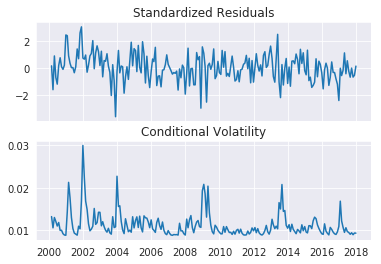

In [141]:
op_res.plot()
plt.show()

### ORR

In [142]:
orr_model = arch_model(m_returns['ORR'], vol='Garch', p=1, o=0, q=1, dist='t')
orr_res = orr_model.fit(update_freq=5, last_obs = split_date)
orr_res.summary()

Iteration:      5,   Func. Count:     70,   Neg. LLF: 1607.7738183375832
Iteration:     10,   Func. Count:    120,   Neg. LLF: 839.6534632099435
Iteration:     15,   Func. Count:    173,   Neg. LLF: 96.43839243702062
Iteration:     20,   Func. Count:    232,   Neg. LLF: 1193.636571059706
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -673.7042469414562
            Iterations: 24
            Function evaluations: 249
            Gradient evaluations: 22


/home/kk385830/miniconda3/envs/quant-invest/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                          ORR   R-squared:                      -0.056
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.056
Vol Model:                            GARCH   Log-Likelihood:                673.704
Distribution:      Standardized Student's t   AIC:                          -1337.41
Method:                  Maximum Likelihood   BIC:                          -1320.56
                                              No. Observations:                  215
Date:                      Mon, Feb 18 2019   Df Residuals:                      210
Time:                              23:09:11   Df Model:                            5
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         9.4654e-04  1.038e-03      0.912      0.362 [-1.087e-03,2.980e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.2903e-05  2.027e-07    112.975      0.000 [2.251e-05,2.330e-05]
alpha[1]       0.8793      0.225      3.911  9.209e-05     [  0.439,  1.320]
beta[1]        0.0742  5.712e-02      1.300      0.194  [-3.771e-02,  0.186]
                               Distribution                               
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
nu            65.4909     25.679      2.550  1.076e-02 [ 15.162,1.158e+02]
==========================================================================

Covariance estimator: robust

WARNING: The optimizer did not indicate successful convergence. The message was
Inequality constraints incompatible. See convergence_flag.
"""

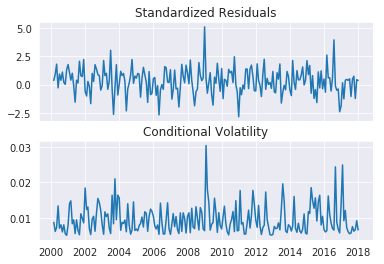

In [143]:
orr_res.plot()
plt.show()

### ORW

In [148]:
orw_model = arch_model(m_returns['ORW'], vol='Garch', p=1, o=0, q=1, dist='t')
orw_res = orw_model.fit(update_freq=5, last_obs = split_date)
orw_res.summary()

Iteration:      5,   Func. Count:     66,   Neg. LLF: 115.21430303738981
Iteration:     10,   Func. Count:    131,   Neg. LLF: -515.2938325768621
Iteration:     15,   Func. Count:    195,   Neg. LLF: -515.5480461285349
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -515.5992176461897
            Iterations: 22
            Function evaluations: 236
            Gradient evaluations: 18


/home/kk385830/miniconda3/envs/quant-invest/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                          ORW   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                515.599
Distribution:      Standardized Student's t   AIC:                          -1021.20
Method:                  Maximum Likelihood   BIC:                          -1004.35
                                              No. Observations:                  215
Date:                      Mon, Feb 18 2019   Df Residuals:                      210
Time:                              23:11:00   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         7.1146e-03  1.936e-03      3.676  2.374e-04 [3.321e-03,1.091e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.0256e-04  3.673e-05      2.792  5.233e-03 [3.057e-05,1.746e-04]
alpha[1]       0.5189      0.158      3.280  1.038e-03     [  0.209,  0.829]
beta[1]        0.2288      0.163      1.404      0.160  [-9.054e-02,  0.548]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu            19.0447      6.876      2.770  5.613e-03 [  5.567, 32.522]
========================================================================

Covariance estimator: robust

WARNING: The optimizer did not indicate successful convergence. The message was
Positive directional derivative for linesearch. See convergence_flag.
"""

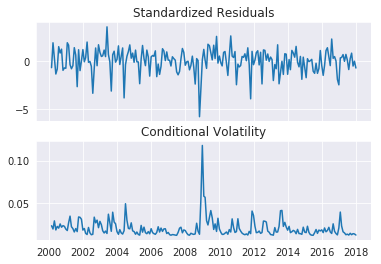

In [147]:
orw_res.plot()
plt.show()

### G

In [149]:
g_model = arch_model(m_returns['G'], vol='Garch', p=1, o=0, q=1, dist='t')
g_res = g_model.fit(update_freq=5, last_obs = split_date)
g_res.summary()

Inequality constraints incompatible    (Exit mode 4)
            Current function value: -1024.5374809446764
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1


/home/kk385830/miniconda3/envs/quant-invest/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                            G   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                1024.54
Distribution:      Standardized Student's t   AIC:                          -2039.07
Method:                  Maximum Likelihood   BIC:                          -2022.22
                                              No. Observations:                  215
Date:                      Mon, Feb 18 2019   Df Residuals:                      210
Time:                              23:11:52   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         4.2158e-03  2.220e-04     18.992  1.974e-80 [3.781e-03,4.651e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.9278e-07  1.848e-09    158.423      0.000 [2.892e-07,2.964e-07]
alpha[1]       0.2000  1.599e-02     12.507  6.817e-36     [  0.169,  0.231]
beta[1]        0.7800  1.359e-02     57.379      0.000     [  0.753,  0.807]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu            12.0000      0.340     35.248 3.655e-272 [ 11.333, 12.667]
========================================================================

Covariance estimator: robust

WARNING: The optimizer did not indicate successful convergence. The message was
Inequality constraints incompatible. See convergence_flag.
"""

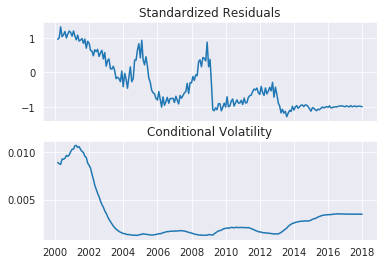

In [150]:
g_res.plot()
plt.show()